## 朴素贝叶斯分类

在分类预测中，以概率论作为基础的算法比较少，而朴素贝叶斯就是其中之一。朴素贝叶斯算法实现简单，且预测分类的效率很高，是一种十分常用的算法。

In [1]:
import pandas as pd


def create_data():
    # 生成示例数据
    data = {
        "x": [
            "r",
            "g",
            "r",
            "b",
            "g",
            "g",
            "r",
            "r",
            "b",
            "g",
            "g",
            "r",
            "b",
            "b",
            "g",
        ],
        "y": [
            "m",
            "s",
            "l",
            "s",
            "m",
            "s",
            "m",
            "s",
            "m",
            "l",
            "l",
            "s",
            "m",
            "m",
            "l",
        ],
        "labels": [
            "A",
            "A",
            "A",
            "A",
            "A",
            "A",
            "A",
            "A",
            "B",
            "B",
            "B",
            "B",
            "B",
            "B",
            "B",
        ],
    }
    data = pd.DataFrame(data, columns=["labels", "x", "y"])
    return data

data = create_data()
data

labels  x  y
0       A  r  m
1       A  g  s
2       A  r  l
3       A  b  s
4       A  g  m
5       A  g  s
6       A  r  m
7       A  r  s
8       B  b  m
9       B  g  l
10      B  g  l
11      B  r  s
12      B  b  m
13      B  b  m
14      B  g  l

### 极大似然估计

极大似然估计提供了一种给定观察数据来评估模型参数的方法，即：「模型已定，参数未知」。通过若干次实验，观察其结果，利用实验结果得到某个参数值能够使样本出现的概率为最大，则称为极大似然估计。

In [2]:
# 求解先验概率P(种类)
def get_P_labels(labels):
    # P({种类}) 先验概率计算
    labels = list(labels)  # 转换为 list 类型
    P_label = {}  # 设置空字典用于存入 label 的概率
    for label in labels:
        # 统计 label 标签在标签集中出现的次数再除以总长度
        P_label[label] = labels.count(label) / float(
            len(labels)
        )  # p = count(y) / count(Y)
    return P_label


P_labels = get_P_labels(data["labels"])
P_labels

{'A': 0.5333333333333333, 'B': 0.4666666666666667}

In [3]:
#先验概率 P（特征|种类）
import numpy as np

def get_P_fea_lab(P_label, features, data):
    # P(\text{特征}∣种类) 先验概率计算
    # 该函数就是求 种类为 P_label 条件下特征为 features 的概率
    P_fea_lab = {}
    train_data = data.iloc[:, 1:]
    train_data = np.array(train_data)
    labels = data["labels"]
    # 遍历所有的标签
    for each_label in P_label.keys():
        # 上面代码的另一种写法，这里就是将标签为 A 和 B 的数据集分开，label_index 中存的是该数据的下标
        label_index = [i for i, label in enumerate(labels) if label == each_label]

        # 遍历该属性下的所有取值
        # 求出每种标签下，该属性取每种值的概率
        for j in range(len(features)):
            # 筛选出该属性下属性值为 features[j] 的数据
            feature_index = [
                i
                for i, feature in enumerate(train_data[:, j])
                if feature == features[j]
            ]

            # set(x_index)&set(y_index) 取交集，得到标签值为 each_label,属性值为 features[j] 的数据集合
            fea_lab_count = len(set(feature_index) & set(label_index))
            key = str(features[j]) + "|" + str(each_label)  # 拼接字符串

            # 计算先验概率
            # 计算 labels 为 each_label下，featurs 为 features[j] 的概率值
            P_fea_lab[key] = fea_lab_count / float(len(label_index))
    return P_fea_lab


features = ["r", "m"]
get_P_fea_lab(P_labels, features, data)


{'r|A': 0.5,
 'm|A': 0.375,
 'r|B': 0.14285714285714285,
 'm|B': 0.42857142857142855}

In [5]:
# 朴素贝叶斯分类器实现
def classify(data, features):
    # 朴素贝叶斯分类器
    # 求 labels 中每个 label 的先验概率
    labels = data["labels"]
    # 这里也就是求 P（B），P_label 为一个字典，存的是每个 B 对应的 P(B)
    P_label = get_P_labels(labels)
    P_fea_lab = get_P_fea_lab(P_label, features, data)  # 这里是在求 P（A|B）

    P = {}
    P_show = {}  # 后验概率
    for each_label in P_label:
        P[each_label] = P_label[each_label]
        # 遍历每个标签下的每种属性
        for each_feature in features:
            # 拼接字符串为 P(B/A) 用于字典的键值
            key = str(each_label) + "|" + str(features)
            # 计算 P(B/A) = P(B) * P(A/B) 因为所有的后验概率，分母相同。因此，在计算时可以忽略掉。
            P_show[key] = (
                P[each_label] * P_fea_lab[str(each_feature) + "|" + str(each_label)]
            )
            # 把刚才算的概率放到 P 列表里面，这个 P 列表的键值变成了标签。
            # 这样做的目的，其实是为了在后面取最大时，取出就是标签，而不是 标签|特征
            P[each_label] = (
                P[each_label] * P_fea_lab[str(each_feature) + "|" + str(each_label)]
            )
    # 输出 P_show 和 P 观察，发现他们的概率值没有变，只是字典的 key 值变了
    print(P_show)
    print(P)
    features_label = max(P, key=P.get)  # 概率最大值对应的类别
    return features_label

classify(data, ["r", "m"])

{"A|['r', 'm']": 0.1, "B|['r', 'm']": 0.02857142857142857}
{'A': 0.1, 'B': 0.02857142857142857}


'A'

### 贝叶斯估计

在做极大似然估计时，若类别中缺少一些特征，则就会出现概率值为 0 的情况。此时，就会影响后验概率的计算结果，使得分类产生偏差。而解决这一问题最好的方法就是采用贝叶斯估计，拉普拉斯平滑。

### 朴素贝叶斯的三种常见模型

在实际数据中，我们可以依照特征的数据类型不同，在计算先验概率方面对朴素贝叶斯模型进行划分，并分为：多项式模型，伯努利模型和高斯模型。

(1) 多项式模型
当特征值为离散时，常常使用多项式模型。事实上，在以上实验的参数估计中，我们所应用的就是多项式模型。为避免概率值为 0 的情况出现，多项式模型采用的是贝叶斯估计。

(2) 伯努利模型
与多项式模型一样，伯努利模型适用于离散特征的情况，所不同的是，伯努利模型中每个特征的取值只能是 1 和 0（以文本分类为例，某个单词在文档中出现过，则其特征值为 1，否则为 0）。

(3) 高斯模型
当特征是连续变量的时候，在不做平滑的情况下，运用多项式模型就会导致很多 p(x|y) = 0，此时即使做平滑，所得到的条件概率也难以描述真实情况。所以处理连续的特征变量，采用高斯模型。高斯模型是假设连续变量的特征数据是服从高斯分布的.

In [28]:
#附：使用python实现高斯分布函数

"""实现高斯分布函数
"""
import numpy as np


def Gaussian(x, u, d):
    """
    参数:
    x -- 变量
    u -- 均值
    d -- 标准差

    返回:
    p -- 高斯分布值
    """
    ### 代码开始 ### (≈ 3~5 行代码)
    p = 1/(np.sqrt(2 * np.pi)*d) * np.exp(-(x - u)**2 /(2 * d **2))

    return p
    ### 代码结束 ###

x = np.linspace(-5, 5, 100)
u = 3.2
d = 5.5
g = Gaussian(x, u, d)

len(g), g[10]

(100, 0.030864654760573856)

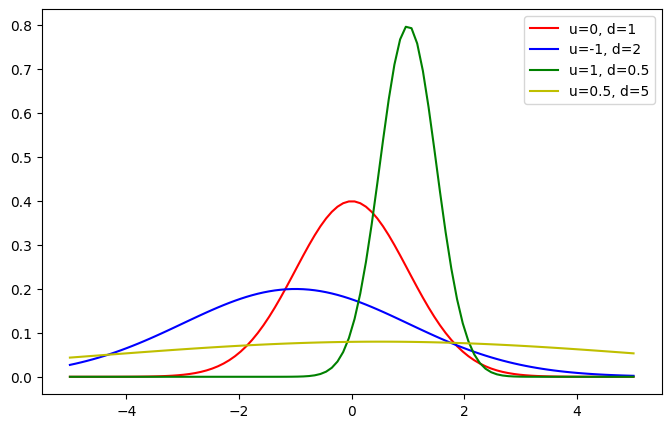

In [29]:
"""
挑战：按规定的参数绘制高斯分布图像。

规定：

绘制 4 组高斯分布线形图像，u 和 d 分别为：(0, 1), (-1, 2), (1, 0.5), (0.5, 5)。

4 组高斯分布图像的线形颜色分别为红色、蓝色、绿色、黄色。

绘制图例，并以 u = d 样式呈现。
"""


from matplotlib import pyplot as plt
%matplotlib inline

### 代码开始 ### (≈ 5~10 行代码)
plt.figure(figsize=(8,5))
plt.plot(x, Gaussian(x, 0, 1), c='r', label="u=0, d=1")
plt.plot(x, Gaussian(x, -1, 2), c='b', label="u=-1, d=2")
plt.plot(x, Gaussian(x, 1, 0.5), c='g', label="u=1, d=0.5")
plt.plot(x, Gaussian(x, 0.5, 5), c='y', label="u=0.5, d=5")
plt.legend()
### 代码结束 ###

In [6]:
## 朴素贝叶斯垃圾邮件分类

"""
首先先了解一下本次实验使用到的数据集: trec06c。

trec06c 是一个公开的垃圾邮件语料库，由国际文本检索会议提供，分为英文数据集（trec06p）和中文数据集（trec06c），其中所含的邮件均来源于真实邮件保留了邮件的原有格式和内容。
"""

import pandas as pd


data = pd.read_table('../../datasets/trec06c/full/index', header=None,
                     encoding='gb2312', delim_whitespace=True)
data.head()


<ipython-input-6-600a6e666bad>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_table('../../datasets/trec06c/full/index', header=None,


0                1
0  spam  ../data/000/000
1   ham  ../data/000/001
2  spam  ../data/000/002
3  spam  ../data/000/003
4  spam  ../data/000/004

读取完成之后，可以看到整个数据集一共有 64620 个样本，第一列代表的是是否是垃圾邮件，标记 spam 是垃圾邮件，标记 ham 是正常邮件。第二列则是邮件内容的文本文件的路径。

接下来用 0 替代 spam，1 替代 ham，然后替换掉文件路径。为了加速运算，本次实验只使用 1 万条样本数据。

In [19]:
df = data.replace(['spam', 'ham'], [0, 1])  # 0 替代 spam，1 替代 ham
df = df.replace(regex=["\.."], value='../../datasets/trec06c')  # 替换掉文件路径
df = df.sample(len(df), random_state=1, )[:10000]  # 打乱样本并取前 1 万条数据
df.groupby(0).count()  # 统计样本

<ipython-input-19-f4b9ced745af>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = data.replace(['spam', 'ham'], [0, 1])  # 0 替代 spam，1 替代 ham


1
0      
0  6595
1  3405

邮件由两部分组成，第一部分包含了邮件的信息，例如发件人，标题等等，第二部分才是邮件正文。这些文件不是 UTF-8 编码的，所以需要将其转为 UTF-8 编码。

由于本次实验会用到的只有邮件正文内容，所以需要去除第一部分，另外正文部分还有许多链接等其他不需要的内容。因此，所以我们需要对原始数据做一些数据预处理，包括以下几个内容。

    - 转换源数据编码格式为 UTF-8 格式。

    - 过滤字符：去除所有非中文字符，如标点符号、英文字符、数字、网站链接等特殊字符。

    - 过滤停用词。

    - 对邮件内容进行分词处理。

数据清洗的步骤中，首先通过正则表达式滤掉了所有英文，数字，标点符号，特殊符号，最后只保留了汉字。与此同时，内容里还存在一些长相奇怪的文字，我们通过 Unicode 中文编码范围 0x4e00-0x9fff 过滤。

In [8]:
import re

def clean_str(line):
    # 清理邮件，替换不需要的字符串
    line.strip('\n')
    line = re.sub(r"[^\u4e00-\u9fff]", "", line)
    line = re.sub(
        "[0-9a-zA-Z\-\s+\.\!\/_,$%^*\(\)\+(+\"\')]+|[+——！，。？、~@#￥%……&*（）<>\[\]:：★◆【】《》;；=?？]+", "", line)
    return line.strip()

In [10]:
def load_stopwords(file_path):
    # 加载停用词
    with open(file_path, 'r') as f:
        stopwords = [line.strip('\n') for line in f.readlines()]
    return stopwords

stopwords = load_stopwords('../../datasets/stopwords.txt')
# stopwords

In [12]:
# 分词

import jieba

def process(file_path, test_mode=False):
    # 清洗一封邮件
    '''
    - file_path: 文本文件路径
    - test_mode: 测试模式，后文我们会将一个字符串写入文件(utf-8 编码)，而训练文件以 GBK 编码，
                 如果自己实现分类，请注意编码格式，通常为 utf-8
    - return: words, 处理、分词之后的有效词语
    '''
    words = []
    with open(file_path, 'rb') as f:
        for line in f.readlines():
            if not test_mode:
                line = line.strip().decode("gbk", 'ignore')
            else:
                line = line.strip().decode("utf-8", 'ignore')
            line = clean_str(line)
            if len(line) == 0:
                continue
            seg_list = list(jieba.cut(line, cut_all=False))
            for x in seg_list:
                if len(x) <= 1:
                    continue
                if x in stopwords:
                    continue
                words.append(x)
    return words

# words = process('../../datasets/trec06c/data/000/000')
# " ".join(words)

Building prefix dict from the default dictionary ...


Dumping model to file cache C:\Users\SUNWEN~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.484 seconds.
Prefix dict has been built successfully.


'上海 培训 课程 财务 纠淼 沙盘 模拟 财务 课程 背景 一位 管理 技术人员 懂得 技术 角度 衡量 合算 方案 也许 却是 财务 陷阱 表面 赢利 亏损 使经 营者 接受 技术手段 财务 运作 相结合 每位 管理 技术人员 老板 角度 思考 规避 财务 陷阱 管理决策 目标 一致性 课程 沙盘 模拟 案例 分析 企业 管理 技术人员 财务管理 知识 利用 财务 信息 改进 管理决策 管理 效益 最大化 学习 课程 会计 财务管理 提高 日常 管理 活动 财务 可行性 业绩 评价 方法 评估 业绩 实施 科学 业绩考核 合乎 财务 墓芾 老板 思维 同步 分析 关键 业绩 指标 战略规划 预算 企业 管理 重心 管理 系统性 课程 大纲 财务 工作 内容 作用 财务会计 财务 专家 思维 模式 财务 工作 内容 管理者 利用 财务 管理 决策 阅读 分析 财务报表 会计报表 损益表 阅读 分析 资产 负债表 阅读 分析 资金 流量 现金流量 阅读 分析 会计报表 之间 关系 会计报表 读懂 企业 状况 案例 分析 报表 判断 企业 业绩 水平 财务 手段 成本 控制 产品成本 概念 本浚利 分析 标准 成本 制度 成本 控制 作用 目标 成本法 控制 产品成本 保证 利润 水平 作业 成本法 管理 分析 实施 精细 成本 管理 沉没 成本 机会成本 正确 决策 改善 采购 生产 环节 运作 改良 企业 整体 财务状况 综合 案例 分析 财务 尚械 墓芾 醴桨 管理 技术 方案 可行性 分析 产品开发 财务 可行性 分析 产品 增产 减产 财务 可行性 分析 生产 设备 改造 更新 决策分析 投资 项目 现金流 分析 投资 项目 评价 方法 现值 法分析 资金 时间 价值 分析 综合 案例 演练 公司 费用 控制 公司 费用 控制 费用 方法 影响 费用 因素 分析 成本 中心 费用 控制 利润 中心 业绩考核 投资 中心 业绩 评价 利用 财务 数据分析 改善 绩效 公司财务 分析 核心 思路 关键 财务指标 解析 盈利 能力 分析 资产 回报率 股东权益 回报率 资产 流动 速率 风险 指数 分析 流动比率 负债 权益 比率 营运 偿债 能力 财务报表 综合 解读 综合 财务 信息 透视 公司 运作 水平 案例 分析 上市公司 财务状况 分析 评价 企业 运

In [20]:
#对全部样本进行分词操作

from tqdm import tqdm

tqdm.pandas()  # 使用 tqdm 显示进度
df
df.replace("..","../../datasets")
# 将 apply 函数替换为 progress_apply 以使用 tqdm 显示处理进度
df["words"] = df[1].progress_apply(process)
df.head()

100%|██████████| 10000/10000 [00:55<00:00, 180.34it/s]


0                                    1  \
37029  1  ../../datasets/trec06c/data/123/129   
2257   0  ../../datasets/trec06c/data/007/157   
50881  1  ../../datasets/trec06c/data/169/181   
10843  0  ../../datasets/trec06c/data/036/043   
4689   0  ../../datasets/trec06c/data/015/189   

                                                   words  
37029  [恋爱, 第三次, 告诉, 再见面, 时间, 我要, 考研, 考到, 北京, 是否是, 喜欢...  
2257   [欣欣, 签约, 推出, 中国, 第一个, 彩铃, 歌手, 稀稀, 龙乐, 公司, 签约, ...  
50881  [男生, 思路, 简单, 心痛, 直说, 原因, 不让, 担心, 他累, 不去, 撒娇, 撒...  
10843                                                 []  
4689   [本港, 会计师, 权威机构, 香港, 瑞丰, 会计师, 事务所, 注册, 海外, 国际, ...

分词结束之后，我们需要对分词结果进一步处理。由于文字无法直接被算法理解，所以这里就需要把分词结果编码为可以输入算法的向量。这里，我们会用到自然语言领域常用的 Word2vec 方法。该方法由 Google 创造，可以阅读 Word2vec-维基百科。

In [23]:
from gensim.models import Word2Vec
from tqdm import tqdm_notebook

# 移除一些不必要的警告
import warnings

warnings.filterwarnings("ignore")

# 导入上面保存的分词数组
data = df["words"]

# 训练 Word2Vec 浅层神经网络模型
w2v_model = Word2Vec(vector_size=100, min_count=10)
w2v_model.build_vocab(data)
w2v_model.train(data, total_examples=w2v_model.corpus_count, epochs=5)
w2v_model

ImportError: cannot import name 'formatargspec' from 'inspect' (c:\Users\SunWenhui\anaconda3\envs\cu\Lib\inspect.py)

In [ ]:
def sum_vec(text):
    # 对每个句子的进行词向量求和计算
    vec = np.zeros(100).reshape((1, 100))
    for word in text:
        try:
            # 得到句子中每个词的词向量并累加在一起
            vec += w2v_model.wv.get_vector(word).reshape((1, 100))
        except KeyError:
            continue
    return vec

# 将词向量保存为 Ndarray
data_vec = np.concatenate([sum_vec(z) for z in tqdm_notebook(data)])
data_vec.shape

In [25]:
# 苏聚集划分与建模
from sklearn.model_selection import train_test_split

feature_data = data_vec
label_data = df[0].values
# 分割数据
X_train, X_test, y_train, y_test = train_test_split(
    feature_data, label_data, test_size=0.2, random_state=4
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

NameError: name 'data_vec' is not defined

scikit-learn 朴素贝叶斯伯努利模型类及参数如下：


    sklearn.naive_bayes.BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)

其中：

alpha 表示平滑参数，如拉普拉斯平滑则 alpha=1。

fit_prior 表示是否使用先验概率，默认为 True。

class_prior 表示类的先验概率。

常用方法:

fit(x,y)选择合适的贝叶斯分类器。

predict(X) 对数据集进行预测返回预测结果。

In [27]:
from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB()  # 定义伯努利模型分类器
model.fit(X_train, y_train)  # 模型训练
y_pred = model.predict(X_test)  # 模型预测
y_pred

NameError: name 'X_train' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)